# CMSC320 Fall 2022 Final Project- Riya Kukadia and Amartya Patel

In [1]:
# Topic: Analysing UFO Sightings Around the World.

# Contributors: Riya Kukadia (117260557) and Amartya Patel (117183986)

# Introduction

UFO is a term that stands for Unidentified Flying Object (also called "UAP" (Unidentified Aerial Phenomena)), which is commonly referred to any aerial phenomena that cannot be instantly identified or explained about. However, after research and serious academic study most UFO sightings have had a reasonable explanation, but there remain some sightings that are yet unexplained.

For more information about the topic: https://www.britannica.com/story/unidentified-flying-objects-what-we-know

In [2]:
# First and foremost, we simply import necessary libraries and tools, that we might/will need for the completeion of this
# project.

import pandas as pd
import numpy as np
import scipy
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas
import sys
import io

# Step 1: Data Collection/Curation

We have obtained this dataset from https://www.kaggle.com/, and have provided the relevant link down below. 

Link: https://www.kaggle.com/datasets/NUFORC/ufo-sightings?resource=download&select=scrubbed.csv


Explaining our Data: 

The following dataset provides a vivid description of UFO sightings that have taken place across the world. The different columns/attributes as part of the dataframe assist in providing more information on the geographical location and physical features of the UFO sighting.

Brief Column Explanations:
1) 'datetime' - Date and Time of UFO sighting.

2) 'city', 'state', 'country' - City, State and Country of the UFO sightings.

3) 'shape' - Aerial physical shape of the UFO sighting.

4) 'duration (seconds)', 'duration(hours/min)' - Duration of the UFO sighting in seconds and in hours/minutes respectively.

5) 'comments' - Other notes/comments about the UFO sighting (description etc.).

6) 'date posted'- Date the UFO sighting was posted in the form of an official record.

7) 'latitude', 'longitude' - Exact geographical coordinates of the UFO sighting.


Size of the Dataset: 80332 (rows), 11 (columns)

Notes:
1) NaN etc. values do exist for data that was not available, unknown etc.

2) Since we are using a ready to use dataset, there is no need to parse the data.

In [3]:
UFO_Dataframe = pd.read_csv('scrubbed.csv', low_memory=False)

UFO_Dataframe.head()

,datetime,city,state,country,shape,duration (seconds),duration (hours/min),comments,date posted,latitude,longitude
0,10/10/1949 20:30,san marcos,tx,us,cylinder,2700,45 minutes,This event took place in early fall around 194...,4/27/2004,29.8830556,-97.941111
1,10/10/1949 21:00,lackland afb,tx,NaN,light,7200,1-2 hrs,1949 Lackland AFB&#44 TX. Lights racing acros...,12/16/2005,29.38421,-98.581082
2,10/10/1955 17:00,chester (uk/england),NaN,gb,circle,20,20 seconds,Green/Orange circular disc over Chester&#44 En...,1/21/2008,53.2,-2.916667
3,10/10/1956 21:00,edna,tx,us,circle,20,1/2 hour,My older brother and twin sister were leaving ...,1/17/2004,28.9783333,-96.645833
4,10/10/1960 20:00,kaneohe,hi,us,light,900,15 minutes,AS a Marine 1st Lt. flying an FJ4B fighter/att...,1/22/2004,21.4180556,-157.803611


# Step 2: Data Management/Representation

It is unequivocally true that the current state of the dataframe has a lot of messy data in several of the columns. 
Subsequently in this step we clean the data in our dataframe, for effective data analysis in the rest of the project.

Instead of having Null, NaN etc. values (as a location) it would be better to replace them with a single common value. Doing so would help us to explore our data better in the next part. Thus, we deal with missing locations by merely tagging them as 'unknown'. 

In [4]:
UFO_Dataframe = UFO_Dataframe.fillna('unknown')

Similarly, it would be better to separate the date and time. Doing so could possibly help in better data analysis. 
Thus, we subsequently separate the 'datetime' column into two separate columns "date" and "time". At the same time, we can remove the 'datetime' column for redundancy as it is no longer needed. 

In [5]:
UFO_Dataframe['datetime'] = UFO_Dataframe['datetime'].apply(lambda x: x.split())
UFO_Dataframe['date'] = UFO_Dataframe['datetime'].apply(lambda x: x[0])
UFO_Dataframe['time'] = UFO_Dataframe['datetime'].apply(lambda x: x[1])
del(UFO_Dataframe['datetime'])

Times such as '24:00' are very ambiguous as well. This is because it is hard to tell which day/date it was actually observed on. 
As a result, for those rows that have a time such as '24:00', we change it to '00:00' and add a day to its date (uniformaly across the dataframe). 

In [6]:
UFO_Dataframe['date'] = pd.to_datetime(UFO_Dataframe['date'])
UFO_Dataframe['next_day'] = (UFO_Dataframe['time'] == '24:00') # Rows where the time is '24:00'
UFO_Dataframe.loc[UFO_Dataframe['next_day'] == True, 'date'] = UFO_Dataframe['date'] + pd.Timedelta(days=1) # Add a day
UFO_Dataframe.loc[UFO_Dataframe['next_day'] == True, 'time'] = '00:00' # Set time to '00:00'
del(UFO_Dataframe['next_day'])

# Convert the 'date' and 'time' to type datetime.
UFO_Dataframe['time'] = pd.to_datetime(UFO_Dataframe['time']).dt.time
UFO_Dataframe['date posted'] = pd.to_datetime(UFO_Dataframe['date posted'])

Next, 'duration(seconds)' contains the same information as 'duration (hours/mins)' but in a much more readable form, thus we do not really need this column and consequently we can remove it. 

In [7]:
del(UFO_Dataframe["duration (hours/min)"]) 

Now, the first few columns of the dataframe give more geographical information, while the last few columns give more information 
about the physical features of the sighting.

In [8]:
# We rename and order the columns for better understanding.
UFO_Dataframe.columns = ["City", "State", "Country", "Shape", "Duration (seconds)", "Notes/Comments", "Date Posted", "Latitude", "Longitude", "Date Observed", "Time Observed"]

UFO_Dataframe = UFO_Dataframe[["Date Observed", "Time Observed", "City", "State", "Country", "Latitude", "Longitude", "Date Posted", "Shape", "Duration (seconds)", "Notes/Comments"]]

While studying through the data we found that one of the Latitudes had invalid data. Consequently, we found its index and dropped that row.

In [9]:
UFO_Dataframe.loc[UFO_Dataframe['Latitude'] == '33q.200088']
UFO_Dataframe = UFO_Dataframe.drop(43782)

On a similar note, when converting duration to float, we found that some of the 'Duration(seconds)' values had an extra '`' at the end. Consequently, we converted the value to string and used the "strip" method to get rid of it.

In [10]:
UFO_Dataframe['Duration (seconds)'] = UFO_Dataframe['Duration (seconds)'].str.strip('`')

Lastly, we convert each of the values in the columns - 'Latitude', 'Longitude', 'Duration (seconds)' to type float, for easier usage in exploring our data in the next segment of the project.

In [11]:
UFO_Dataframe['Latitude'] = UFO_Dataframe['Latitude'].astype(float)
UFO_Dataframe['Longitude'] = UFO_Dataframe['Longitude'].astype(float)
UFO_Dataframe['Duration (seconds)'] = UFO_Dataframe['Duration (seconds)'].astype(float)

We have now effectively cleaned the data in our dataframe.

In [12]:
# Dataframe after cleaning the data.
UFO_Dataframe.head()

,Date Observed,Time Observed,City,State,Country,Latitude,Longitude,Date Posted,Shape,Duration (seconds),Notes/Comments
0,1949-10-10,20:30:00,san marcos,tx,us,29.883056,-97.941111,2004-04-27,cylinder,2700.0,This event took place in early fall around 194...
1,1949-10-10,21:00:00,lackland afb,tx,unknown,29.384210,-98.581082,2005-12-16,light,7200.0,1949 Lackland AFB&#44 TX. Lights racing acros...
2,1955-10-10,17:00:00,chester (uk/england),unknown,gb,53.200000,-2.916667,2008-01-21,circle,20.0,Green/Orange circular disc over Chester&#44 En...
3,1956-10-10,21:00:00,edna,tx,us,28.978333,-96.645833,2004-01-17,circle,20.0,My older brother and twin sister were leaving ...
4,1960-10-10,20:00:00,kaneohe,hi,us,21.418056,-157.803611,2004-01-22,light,900.0,AS a Marine 1st Lt. flying an FJ4B fighter/att...


# Step 3: Exploratory Data Analysis

In this part, we hope to explore different trends in our data through visualization!

Since, the topic of UFO's is extremely intriguing, we can first see the distribution of the UFO sightings all across the world. This can help us visually to conclude which areas (particularly different countries) of the world have had more UFO sightings as compared to the other areas.

To do so we use geopandas, which will be best suited for a situation such as this.

C:\Users\amartya\anaconda3\lib\site-packages\geopandas\array.py:275: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  return GeometryArray(vectorized.points_from_xy(x, y, z), crs=crs)


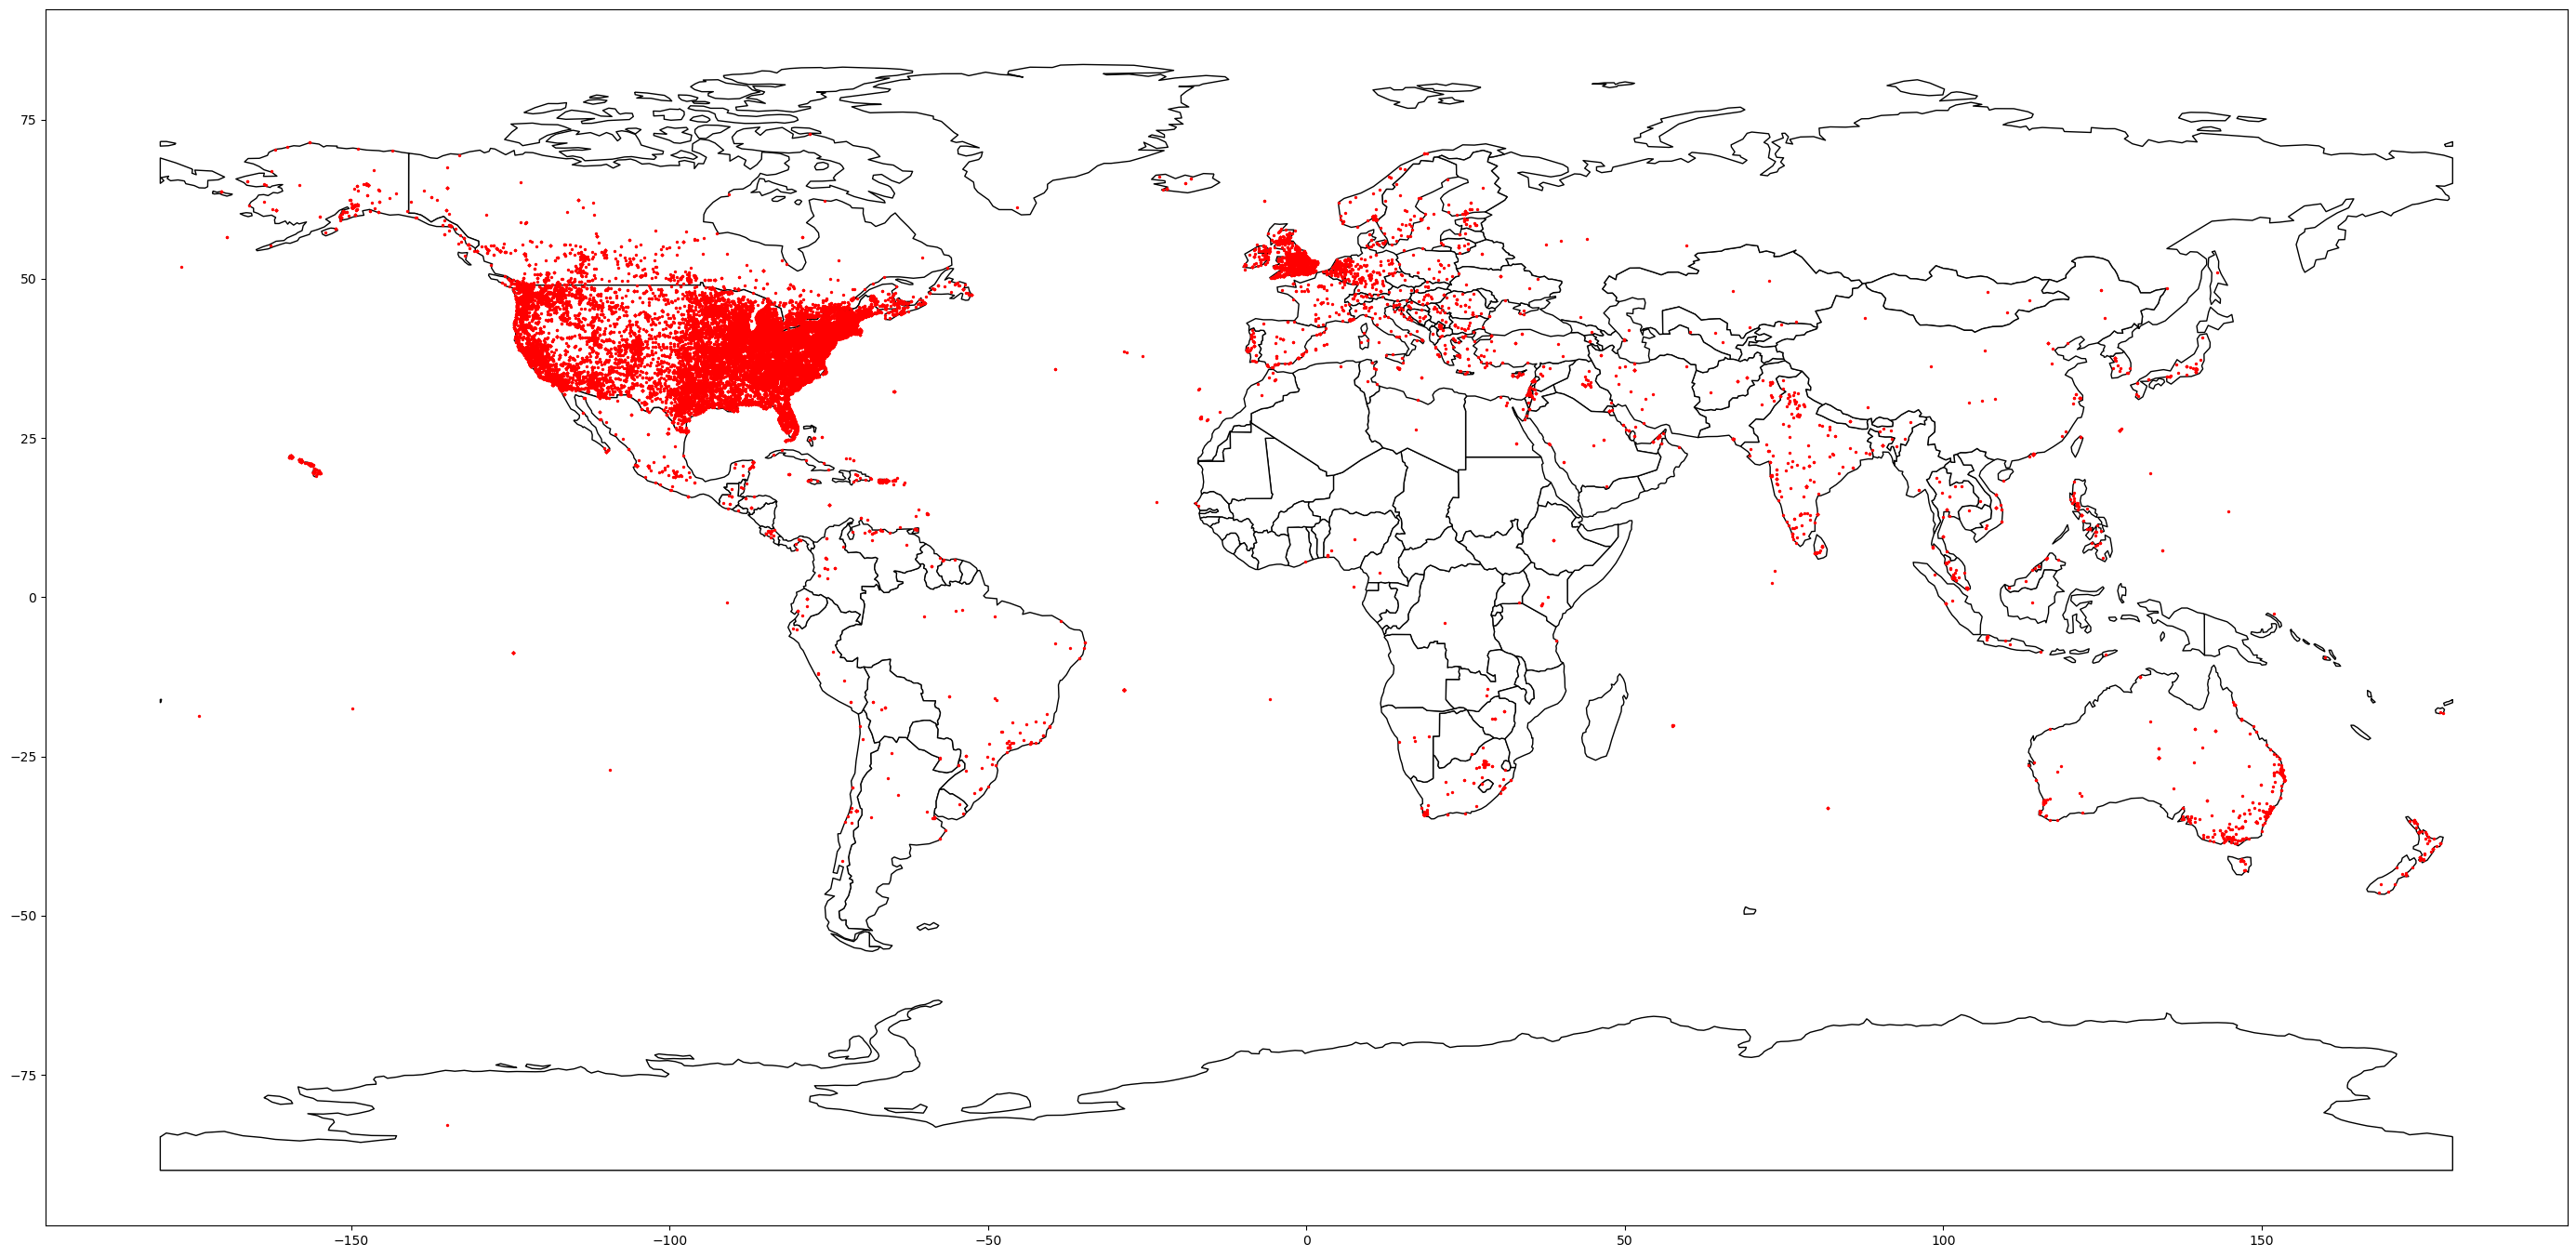

In [13]:
Geo_Dataframe = geopandas.GeoDataFrame(UFO_Dataframe, geometry=geopandas.points_from_xy(UFO_Dataframe['Longitude'], UFO_Dataframe['Latitude']))
UFO_World_Plot = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

ax = UFO_World_Plot.plot(color='white', edgecolor='black', figsize=(35, 35))

# We can now plot our 'Geo_Dataframe'.
Geo_Dataframe.plot(ax=ax, color='red', markersize=2, legend=True)

plt.show()

The following plot shows the distribution of UFO sightings across the world. We see that a bulk of the sightings occur in North America. Another large cluster can be seen over Great Britain. There are relatively fewer observations across other countries. It is also interesting that some UFOs have been sighted over the ocean. 

Since there are so many observations in the USA, we can dive a bit more deeper to look at where in the US (across the different states) you are more likely to sight a UFO.

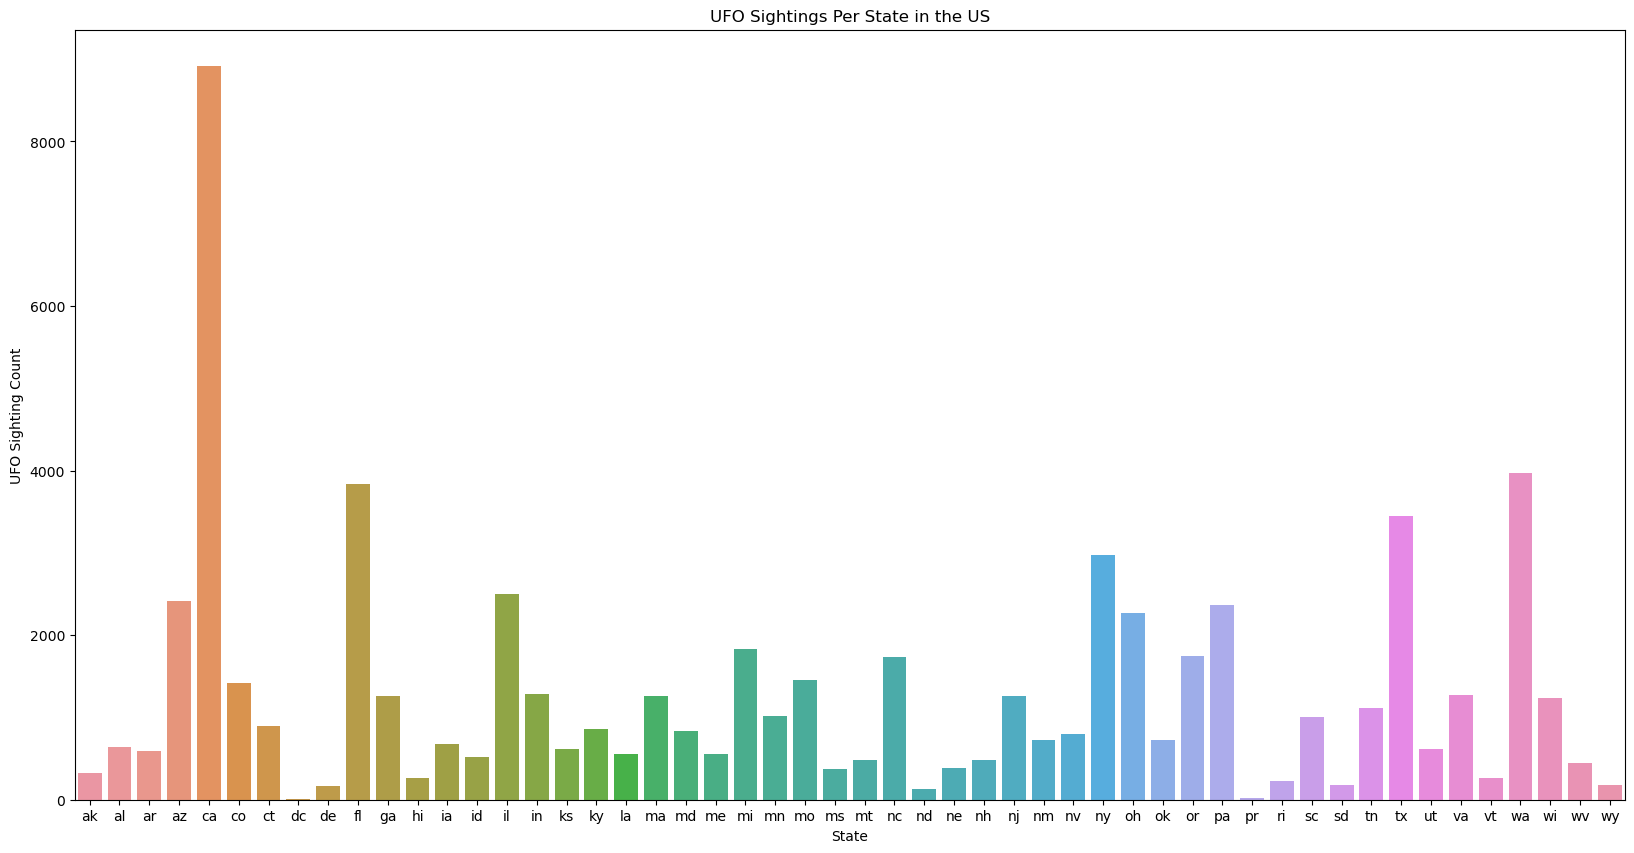

In [14]:
USA_sightings = UFO_Dataframe.groupby('Country').get_group('us')
USA_per_state = USA_sightings.groupby('State').size().reset_index()

# Use log scale on the y axis since the number of sightings across states is very skewed???

USA_per_state.columns = ["State", "Count"]
fig, ax = plt.subplots(figsize=(20, 10))

# We use seaborn to plot, it is a great data visualization tool.

# Since it is used repeatedly thoughout the project here are some important details:
# data = data we are working on.
# x = specification of the x-axis.
# y = specofcation of the y-axis.
# heigh, aspect = size of the plot.
# hue = differenciates color based on that attribute.
# kind = what type of graph = scattered, lined etc.

plot = sns.barplot(data = USA_per_state, x = "State", y = "Count")

# Set the labels so that the graph is more understandable!
plot = plot.set(xlabel = "State", ylabel = "UFO Sighting Count", title ='UFO Sightings Per State in the US')

plt.show()

The following barplot shows the Number of UFO sightings across the different states in the USA.
We see that California has a much higher number of sightings than any other state, followed by Washington, Florida and Texas. So you are most likely to sight a UFO from California.

Next, since UFOs are a topic we are still learning and studying about, it would also be important to analyze them through
their shape. 

Thus, with the data at hand, we can first analyze how many UFO sightings of a particular shape have occurred.

The following command counts the number of unique values in the 'Shape' column in the UFO dataframe.

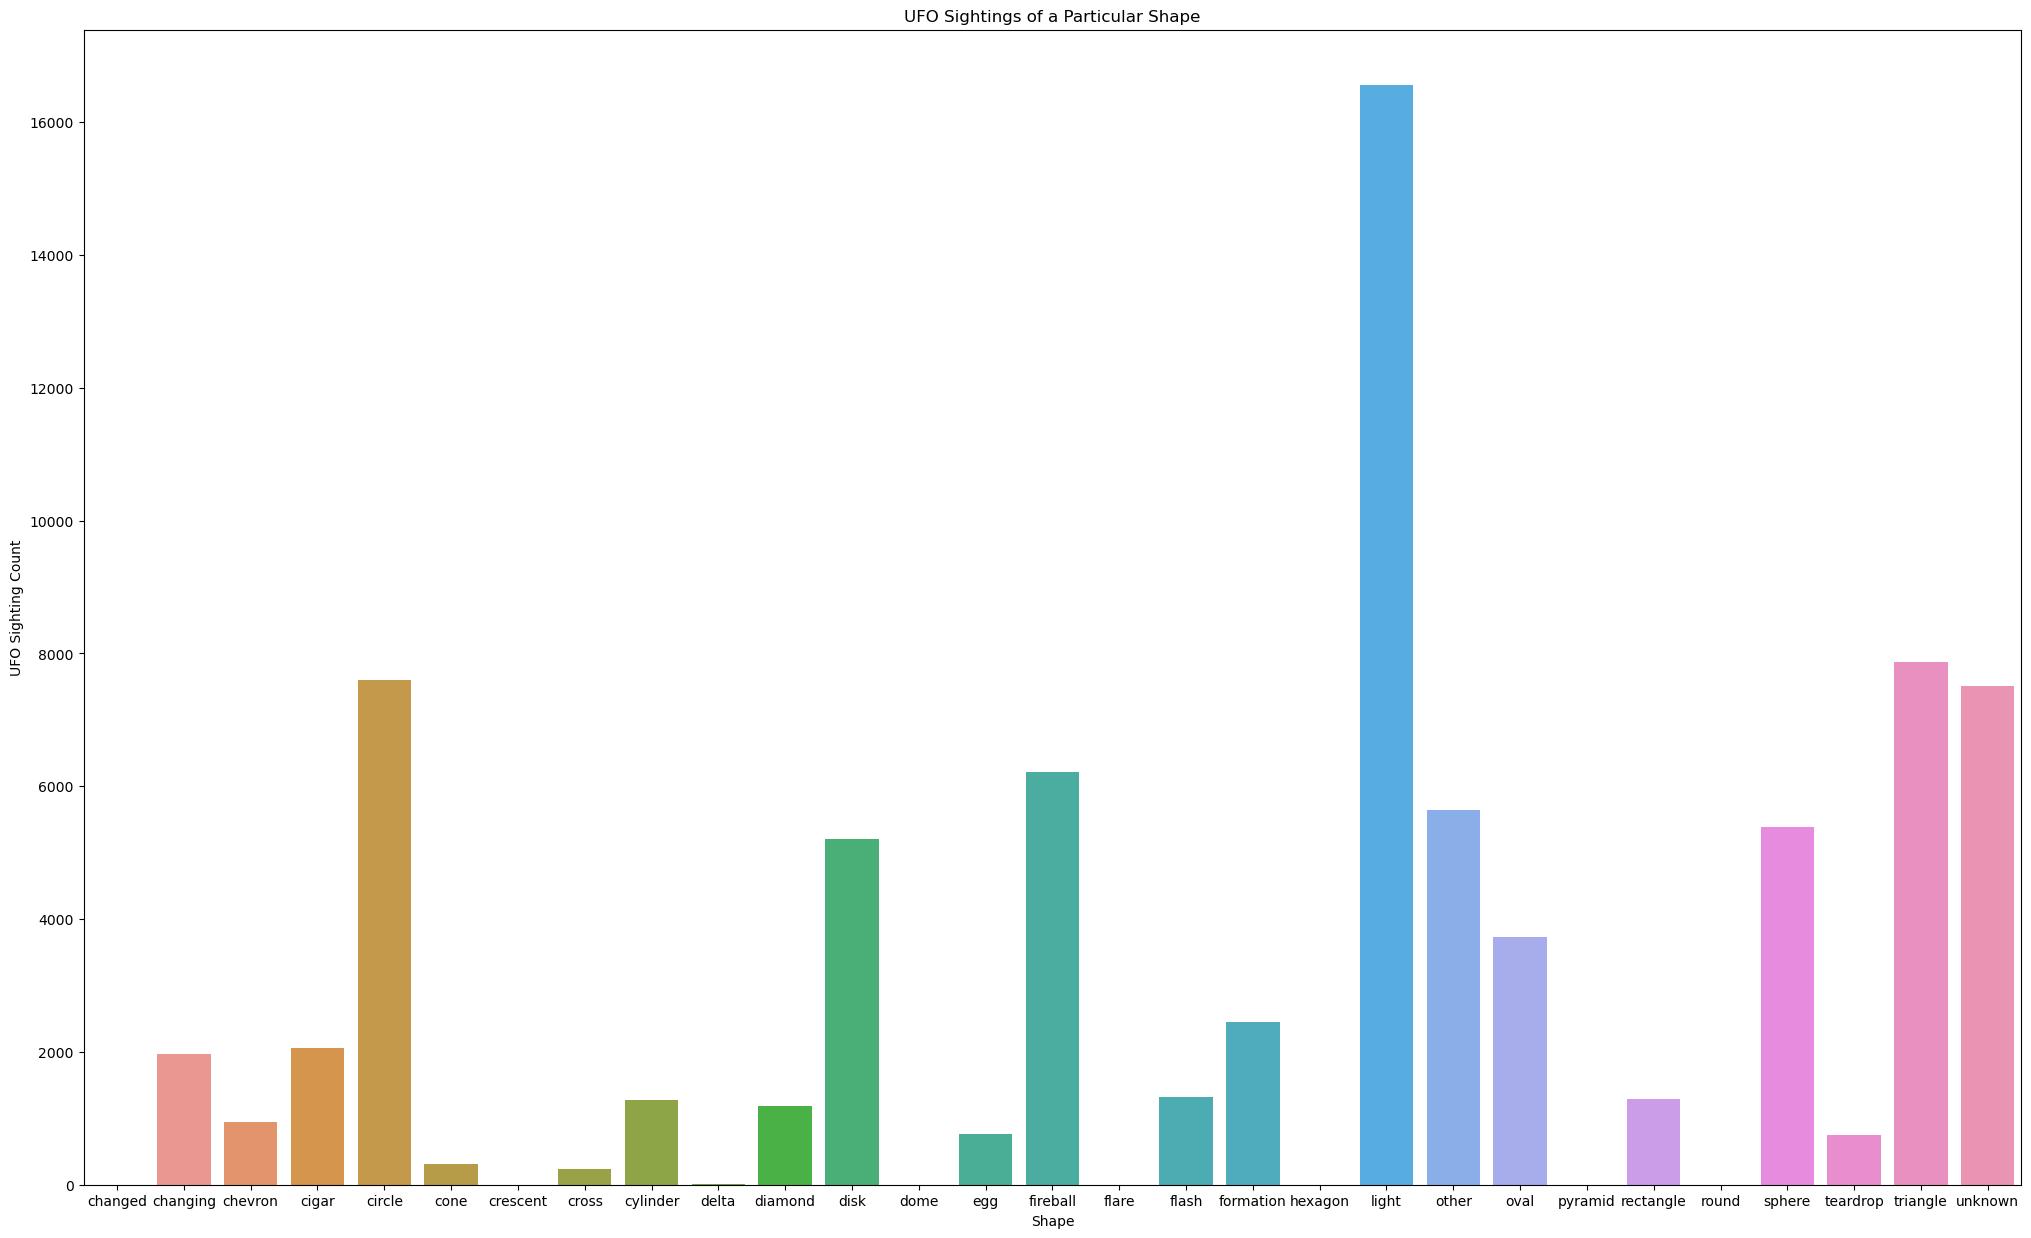

In [15]:
UFO_Shape_Count = UFO_Dataframe.groupby('Shape').size().reset_index()

# Rename the columns for better understanding.
UFO_Shape_Count.columns = ["Shape", "Count"]

fig, ax = plt.subplots(figsize=(25, 15))

UFO_Shape_Count_plot = sns.barplot(data = UFO_Shape_Count, x = "Shape", y = "Count")

# Set the labels so that the graph is more understandable!
UFO_Shape_Count_plot = UFO_Shape_Count_plot.set(xlabel = "Shape", ylabel = "UFO Sighting Count", title ='UFO Sightings of a Particular Shape')

plt.show()

Thus, the following plot shows the number of UFO sightings of a particular shape. It can be inferred that most of the sightings were reported to have shape of "moving light". A substantial number of sightings also were circular and triangular in shape. A good number of UFO sightings were also hard to describe and thus were reported with a shape of "unknown".

Next, in the same vein we can analyze the shape of the UFO sightings with respect to time (in years) to see if any particular
shape is particularly seen more often (over time).

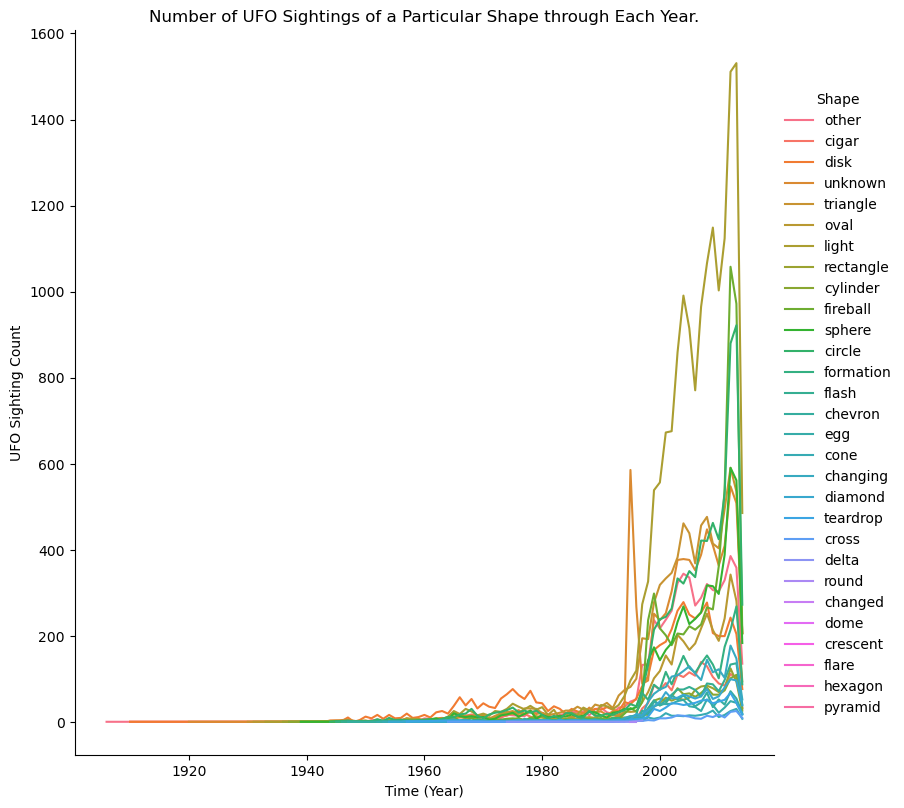

In [16]:
UFO_Shape_Time = UFO_Dataframe

# Extract the Year from the datetime object.
UFO_Shape_Time["Year Observed"] = pd.DatetimeIndex(UFO_Shape_Time["Date Observed"]).year

# We do not really need the other columns in the plot we hope to achieve.
UFO_Shape_Time = UFO_Shape_Time[["Year Observed", "Shape"]]

# The following line computes the number of UFO sightings of a particular shape through each year.
UFO_Shape_Time = UFO_Shape_Time.groupby(['Year Observed', 'Shape']).size().reset_index()

UFO_Shape_Time.columns = ["Year Observed", "Shape", "Count"]

UFO_Shape_Time_plot = sns.relplot(data = UFO_Shape_Time, x = "Year Observed", y = "Count", height = 8, aspect = 1, hue = "Shape", kind = "line")

# Set the labels so that the graph is more understandable!
UFO_Shape_Time_plot = UFO_Shape_Time_plot.set(xlabel = "Time (Year)", ylabel = "UFO Sighting Count", title = 'Number of UFO Sightings of a Particular Shape through Each Year.')

plt.show()

The following line plot shows the number of UFO sightings for each shape over time, which is increasing (for almost each and every shape). Particularly, we can see an obvious increase in the number of "moving light" shaped UFOs over time, which nearly had close to 1600 sightings in a single year itself. Moreover, in the late 1990's, there was a sudden spike of UFO sightings whose shape was ambiguous and hard to determine. Lastly, towards the end we can also see a small spike in UFO sightings that have a shape constituing of "fireball" and "circle".

Given our analysis on the aspect of "shape" of the UFO sightings, the above line plot seems to hint on the idea that the 
number of UFO sightings over time has substantially increased. 

Thus, we can now analyze this more concretely, to see a correlation between UFO sightings and Time (in years) in general.

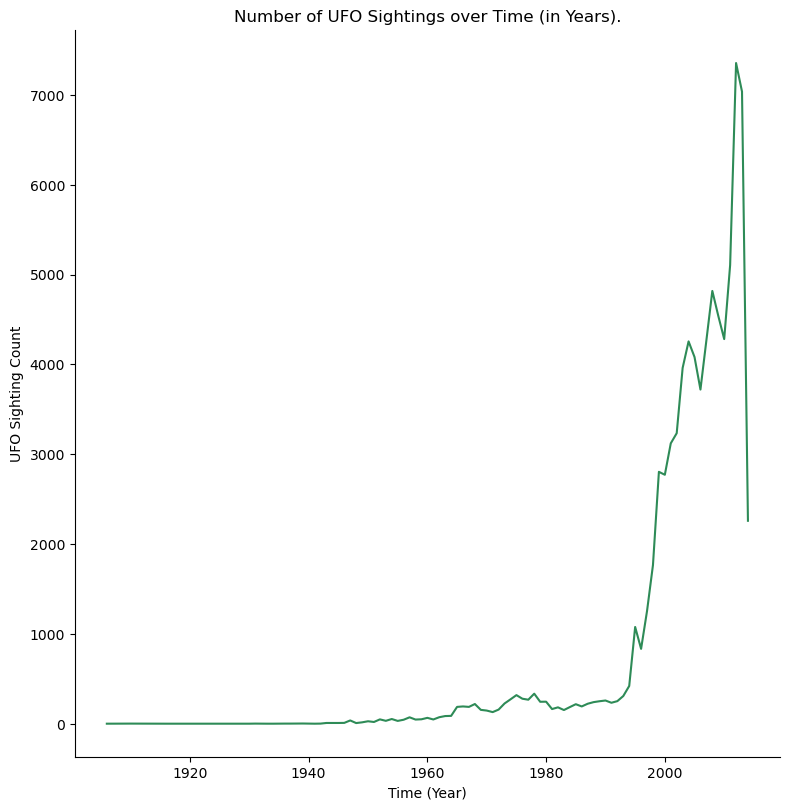

In [17]:
UFO_Sightings_Time = UFO_Dataframe

# Extract the Year from the datetime object.
UFO_Sightings_Time["Year Observed"] = pd.DatetimeIndex(UFO_Sightings_Time["Date Observed"]).year

# We do not really need the other columns in the plot we hope to achieve.
UFO_Sightings_Time = UFO_Sightings_Time[["Year Observed"]]

UFO_Sightings_Time = UFO_Sightings_Time.groupby('Year Observed').size().reset_index()

UFO_Sightings_Time.columns = ["Year Observed", "Count"]

UFO_Sightings_Time_plot = sns.relplot(data = UFO_Sightings_Time, x = "Year Observed", y = "Count", height = 8, aspect = 1, kind = "line", color = "seagreen")

# Set the labels so that the graph is more understandable!
UFO_Sightings_Time_plot = UFO_Sightings_Time_plot.set(xlabel = "Time (Year)", ylabel = "UFO Sighting Count", title = 'Number of UFO Sightings over Time (in Years).')

plt.show()

The plot above shows the correlation between the Number of UFO Sightings and Time (in years). The upward trend of the graph unequivocally suggests that UFO sightings in general have significantly increased over time (in years). Moreover, post year 2000 there has been a sharp increase in the number of UFO sightings. In the same vein, towards the end of the plot (compared to the beginning of around 0 - < 100 sightings) it can also be inferred that over 7000 sightings were observed in a single year!

Note: The sudden dip at the end could be due to an incomplete count in a particular year. For instance the data in our dataset might have stopped after say August 2020, midway through a year which resulted in fewer counts for the year of 2020 (example).

Given our analysis between UFO sightings and Time (in years), we can look a bit more into this. We can dissect each year to
see if you are more likely to observe UFOs at a certain time of the year (that is, any particular month or so).

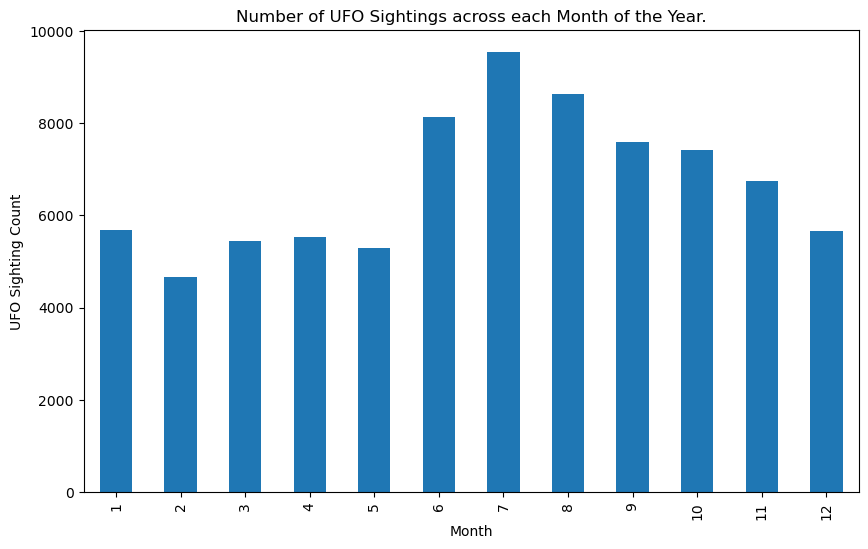

In [18]:
UFO_Dataframe['Month'] = UFO_Dataframe['Date Observed'].dt.month

# The following line computes the number of UFO sightings across each month of the year and plots a barplot accordingly.
UFO_Dataframe.groupby('Month').size().plot(kind = 'bar', figsize=(10, 6))

# Set the labels so that the graph is more understandable! 

plt.title("Number of UFO Sightings across each Month of the Year.")

plt.xlabel("Month")

plt.ylabel("UFO Sighting Count")

plt.show()

The following plot shows Number of UFO sightings across each Month of the Year through the entire dataset. It can be 
concluded that the latter months (June - December) have more UFO sightings that the first few months (January - May). Other 
than that, the months June, July and August have the most UFO sightings, the most being July with close to 10,000 UFO sightings
in our dataset.

In [19]:
#So what were some of the longest sightings appear
UFO_Dataframe['Duration (seconds)'].nlargest(10) #not sure what to do with this

559      97836000.0
53384    82800000.0
74660    66276000.0
38261    52623200.0
64390    52623200.0
69215    52623200.0
52709    25248000.0
6991     10526400.0
30596    10526400.0
71172    10526400.0
Name: Duration (seconds), dtype: float64

# Step 4: Hypothesis Testing